# Base Model

## 準備

In [36]:
# from google.colab import drive
# drive.mount('/content/drive')

In [37]:
# %pip install -q catboost

In [38]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings

warnings.filterwarnings("ignore")
import random
import scipy as sp
import numpy as np
import pandas as pd
import polars as pl
from glob import glob
from pathlib import Path
import joblib
import pickle
import itertools
from tqdm.auto import tqdm

#import torch
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import log_loss, roc_auc_score, matthews_corrcoef, f1_score

import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostClassifier

In [39]:
# ====================================================
# Configurations
# ====================================================
class CFG:
    VER = 1
    AUTHOR = "Jun-Morita"
    COMPETITION = "titanic"
    MAIN_PATH = Path.cwd()
    DATA_PATH = Path(f"{MAIN_PATH}/data")
    OOF_DATA_PATH = Path(f"{MAIN_PATH}/oof")
    MODEL_DATA_PATH = Path(f"{MAIN_PATH}/models")
    METHOD_LIST = ["lightgbm", "xgboost", "catboost"]
    METHOD_WEIGHT_DICT = {"lightgbm": 1 / 3, "xgboost": 1 / 3, "catboost": 1 / 3}
    #USE_GPU = torch.cuda.is_available()
    SEED = 42
    N_SEEDS = 5
    N_SPLIT = 3
    target_col = "Survived"
    group_col = ""
    metric = "auc"
    metric_maximize_flag = True

    num_boost_round = 2500
    early_stopping_round = 50
    verbose = 100

    lgb_params = {
        "objective": "binary",
        "metric": "auc",  # 'binary_logloss',
        "learning_rate": 0.05,
        "num_leaves": 6,
        "seed": SEED,
        "verbosity": -1,
    }

    xgb_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",  # 'logloss',
        "learning_rate": 0.05,
        "max_depth": 3,
        "random_state": SEED,
    }

    cat_params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",  #
        "learning_rate": 0.05,
        "iterations": num_boost_round,
        "depth": 3,
        "random_seed": SEED,
    }

In [40]:
# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


seed_everything(CFG.SEED)

In [41]:
# ====================================================
# Timer
# ====================================================
from contextlib import contextmanager
from time import time


class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):
        if prefix:
            format_str = str(prefix) + sep + format_str
        if suffix:
            format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [42]:
def calc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

## Read Data

In [43]:
# ====================================================
# Read Data
# ====================================================
# 基本的なデータ
train_df = pd.read_csv(CFG.DATA_PATH / "train.csv")
test_df = pd.read_csv(CFG.DATA_PATH / "test.csv")
submission_df = pd.read_csv(CFG.DATA_PATH / "gender_submission.csv")

## EDA

In [44]:
display(train_df)
display(test_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [45]:
display(train_df.describe())
display(test_df.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [46]:
display(train_df.describe(include="object"))
display(test_df.describe(include="object"))

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


In [47]:
display(train_df.isna().sum())
display(test_df.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Preprocessing data

In [48]:
def create_pclass_feature(input_df):
    df = input_df.copy()
    return df[["Pclass"]]

In [49]:
def create_name_feature(input_df):
    df = input_df.copy()

    # title抽出
    def get_title(name):
        title = name.split(",")[1].split(".")[0].strip()
        return title.strip()

    df["Title"] = df["Name"].apply(get_title)

    # titleグルーピング
    def group_titles(row):
        title = row["Title"]
        if title in ["Don", "Major", "Jonkheer", "Sir"]:
            return "Mr"
        elif title in ["the Countess", "Mme", "Lady", "Dona"]:
            return "Mrs"
        elif title in ["Mlle", "Ms"]:
            return "Miss"
        elif title in ["Dr", "Capt", "Rev", "Col"]:
            if row["Sex"] == "male":
                return "Mr"
            else:
                return "Mrs"
        else:
            return title

    df["Title"] = df.apply(group_titles, axis=1)

    # One-hot化（Mr, Mrs, Miss, Master だけに限定）
    title_dummies = pd.get_dummies(df["Title"])
    title_dummies = title_dummies.reindex(
        columns=["Mr", "Mrs", "Miss", "Master"], fill_value=0
    )

    return title_dummies

In [50]:
def create_sex_feature(input_df):
    df = input_df.copy()
    return df["Sex"].map({"male": 1, "female": 0}).astype(int)

In [51]:
def create_age_feature(input_df):
    df = input_df.copy()

    df["Age"] = df.groupby(["Sex", "Pclass"])["Age"].transform(lambda x: x.fillna(x.median()))
    return df[["Age"]]

In [52]:
def create_familysize_feature(input_df):
    df = input_df.copy()
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    return df[["FamilySize"]]

In [53]:
def create_fare_feature(input_df):
    df = input_df.copy()
    df["Fare"] = pd.cut(df["Fare"], bins=[0.0, 7.9, 14.45, 31, 512], labels=[0, 1, 2, 3])
    df["Fare"] = df["Fare"].fillna(0).astype(int)
    return df[["Fare"]]

In [54]:
def create_cabin_feature(input_df):
    df = input_df.copy()

    def extract_cabin_alpha(cabin):
        cabin = str(cabin)
        if cabin == "nan":
            return "M"
        else:
            return cabin[0]

    df["Deck"] = df["Cabin"].apply(extract_cabin_alpha)

    def group_deck(deck):
        if deck in ["A", "B", "C", "T"]:
            return 0
        elif deck in ["D", "E"]:
            return 1
        elif deck in ["F", "G"]:
            return 2
        else:
            return 3

    df["Deck"] = df["Deck"].apply(group_deck)
    return df[["Deck"]]

In [55]:
def create_embarked_feature(input_df):
    df = input_df.copy()
    df["Embarked"] = df["Embarked"].fillna("S")

    return df["Embarked"].map({"C": 0, "Q": 1, "S": 2})

In [56]:
from typing import List, Optional


def build_feature(input_df: pd.DataFrame, feature_functions: List) -> pd.DataFrame:
    # 出力するデータフレームを空で用意して
    out_df = pd.DataFrame()

    print("start build features...")

    # 各特徴生成関数ごとで
    for func in feature_functions:
        with Timer(prefix=f"create {func.__name__}"):
            # 特徴量を作成し
            _df = func(input_df)

        # 横方向 (axis=1) にがっちゃんこ (concat) する
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [57]:
feature_functions = [
    create_pclass_feature,
    create_name_feature,
    create_sex_feature,
    create_age_feature,
    create_familysize_feature,
    create_fare_feature,
    create_cabin_feature,
    create_embarked_feature,
]

In [58]:
feat_train_df = build_feature(input_df=train_df, feature_functions=feature_functions)
feat_test_df = build_feature(input_df=test_df, feature_functions=feature_functions)

train_full_df = pd.concat([train_df[CFG.target_col], feat_train_df], axis=1)

features = feat_train_df.columns.tolist()
categorical_features = []

display(features)
display(train_full_df)
display(feat_test_df)

start build features...
create create_pclass_feature 0.001[s]
create create_name_feature 0.004[s]
create create_sex_feature 0.000[s]
create create_age_feature 0.002[s]
create create_familysize_feature 0.000[s]
create create_fare_feature 0.001[s]
create create_cabin_feature 0.001[s]
create create_embarked_feature 0.000[s]
start build features...
create create_pclass_feature 0.000[s]
create create_name_feature 0.002[s]
create create_sex_feature 0.000[s]
create create_age_feature 0.002[s]
create create_familysize_feature 0.000[s]
create create_fare_feature 0.001[s]
create create_cabin_feature 0.001[s]
create create_embarked_feature 0.000[s]


['Pclass',
 'Mr',
 'Mrs',
 'Miss',
 'Master',
 'Sex',
 'Age',
 'FamilySize',
 'Fare',
 'Deck',
 'Embarked']

,Survived,Pclass,Mr,Mrs,Miss,Master,Sex,Age,FamilySize,Fare,Deck,Embarked
0,0,3,True,False,False,False,1,22.0,2,0,3,2
1,1,1,False,True,False,False,0,38.0,2,3,0,0
2,1,3,False,False,True,False,0,26.0,1,1,3,2
3,1,1,False,True,False,False,0,35.0,2,3,0,2
4,0,3,True,False,False,False,1,35.0,1,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,True,False,False,False,1,27.0,1,1,3,2
887,1,1,False,False,True,False,0,19.0,1,2,0,2
888,0,3,False,False,True,False,0,21.5,4,2,3,2
889,1,1,True,False,False,False,1,26.0,1,2,0,0


,Pclass,Mr,Mrs,Miss,Master,Sex,Age,FamilySize,Fare,Deck,Embarked
0,3,True,False,False,False,1,34.5,1,0,3,1
1,3,False,True,False,False,0,47.0,2,0,3,2
2,2,True,False,False,False,1,62.0,1,1,3,1
3,3,True,False,False,False,1,27.0,1,1,3,2
4,3,False,True,False,False,0,22.0,3,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...
413,3,True,False,False,False,1,24.0,1,1,3,2
414,1,False,True,False,False,0,39.0,1,3,0,0
415,3,True,False,False,False,1,38.5,1,0,3,2
416,3,True,False,False,False,1,24.0,1,1,3,2


## Machine Learning

In [59]:
model_dict = {}


def lightgbm_training(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_valid: pd.DataFrame,
    y_valid: pd.DataFrame,
    features: list,
    categorical_features: list,
):
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(x_valid, y_valid, categorical_feature=categorical_features)
    model = lgb.train(
        params=CFG.lgb_params,
        train_set=lgb_train,
        num_boost_round=CFG.num_boost_round,
        valid_sets=[lgb_train, lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=CFG.early_stopping_round, verbose=CFG.verbose),
            lgb.log_evaluation(CFG.verbose),
        ],
    )
    # Predict validation
    valid_pred = model.predict(x_valid)
    return model, valid_pred


def xgboost_training(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_valid: pd.DataFrame,
    y_valid: pd.DataFrame,
    features: list,
    categorical_features: list,
):
    xgb_train = xgb.DMatrix(data=x_train, label=y_train, enable_categorical=True)
    xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid, enable_categorical=True)
    model = xgb.train(
        CFG.xgb_params,
        dtrain=xgb_train,
        num_boost_round=CFG.num_boost_round,
        evals=[(xgb_train, "train"), (xgb_valid, "eval")],
        early_stopping_rounds=CFG.early_stopping_round,
        verbose_eval=CFG.verbose,
    )
    # Predict validation
    valid_pred = model.predict(xgb.DMatrix(x_valid, enable_categorical=True))
    return model, valid_pred


def catboost_training(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_valid: pd.DataFrame,
    y_valid: pd.DataFrame,
    features: list,
    categorical_features: list,
):
    cat_train = Pool(data=x_train, label=y_train, cat_features=categorical_features)
    cat_valid = Pool(data=x_valid, label=y_valid, cat_features=categorical_features)
    model = CatBoostClassifier(**CFG.cat_params)
    model.fit(
        cat_train,
        eval_set=[cat_valid],
        early_stopping_rounds=CFG.early_stopping_round,
        verbose=CFG.verbose,
        use_best_model=True,
    )
    # Predict validation
    valid_pred = model.predict_proba(x_valid)[:, 1]
    return model, valid_pred


def gradient_boosting_model_cv_training(
    method: str, train_df: pd.DataFrame, features: list, categorical_features: list, seed: int
):
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train_df))
    oof_fold = np.zeros(len(train_df))
    target_col = CFG.target_col

    # kfoldはタスクによって変更
    kfold = StratifiedKFold(n_splits=CFG.N_SPLIT, shuffle=True, random_state=seed)
    # kfold = GroupKFold(n_splits=CFG.N_SPLIT, shuffle=True, random_state=seed)

    for fold, (train_index, valid_index) in enumerate(
        kfold.split(train_df[features], train_df[CFG.target_col])
    ):
        print("-" * 50)
        print(f"{method} (seed {seed}) training fold {fold+1}")
        x_train = train_df[features].iloc[train_index]
        y_train = train_df[target_col].iloc[train_index]
        x_valid = train_df[features].iloc[valid_index]
        y_valid = train_df[target_col].iloc[valid_index]
        if method == "lightgbm":
            model, valid_pred = lightgbm_training(
                x_train, y_train, x_valid, y_valid, features, categorical_features
            )
            importance_df = pd.DataFrame(
                model.feature_importance(), index=features, columns=["importance"]
            ).reset_index()
            importance_df.to_csv(
                CFG.MODEL_DATA_PATH
                / f"{CFG.AUTHOR}_{method}_{target_col}_fold{fold + 1}_seed{seed}_ver{CFG.VER}_importance.csv",
                index=False,
            )
        if method == "xgboost":
            model, valid_pred = xgboost_training(
                x_train, y_train, x_valid, y_valid, features, categorical_features
            )
        if method == "catboost":
            model, valid_pred = catboost_training(
                x_train, y_train, x_valid, y_valid, features, categorical_features
            )
        # Save best model
        pickle.dump(
            model,
            open(
                CFG.MODEL_DATA_PATH
                / f"{CFG.AUTHOR}_{method}_{target_col}_fold{fold + 1}_seed{seed}_ver{CFG.VER}.pkl",
                "wb",
            ),
        )
        model_dict[f"{method}_{target_col}_fold{fold+1}_seed{seed}"] = model
        
        # Add to out of folds array
        oof_predictions[valid_index] = valid_pred
        del x_train, x_valid, y_train, y_valid, model, valid_pred
        gc.collect()
        oof_fold[valid_index] = fold + 1

    oof_df = pd.DataFrame(
        {
            CFG.target_col: oof_predictions.astype(float),
            "fold": oof_fold.astype(int),
            "row_id": train_df.index,
        }
    )

    y_true = train_df[CFG.target_col].values
    score = calc_score(y_true, oof_df[CFG.target_col].values)
    print(f"{method} (seed {seed}) our out of folds CV {CFG.metric} is {score}")

    oof_path = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{method}_seed{seed}_ver{CFG.VER}.csv"
    oof_df.to_csv(oof_path, index=False)

    return score

In [60]:
for method in CFG.METHOD_LIST:
    scores = []
    for seed_idx in range(CFG.N_SEEDS):
        seed = CFG.SEED + seed_idx
        print("=" * 50)
        print(f"Training {method} with seed {seed} ({seed_idx + 1}/{CFG.N_SEEDS})")
        print("=" * 50)
        score = gradient_boosting_model_cv_training(method, train_full_df, features, categorical_features, seed)
        scores.append(score)

    print("=" * 50)
    print(f"{method} Seed Averaging Results:")
    print(f"  Seeds: {[CFG.SEED + i for i in range(CFG.N_SEEDS)]}")
    print(f"  Scores: {scores}")
    print(f"  Mean: {np.mean(scores):.6f}")
    print(f"  Std: {np.std(scores):.6f}")
    print("=" * 50)

Training lightgbm with seed 42 (1/5)
--------------------------------------------------
lightgbm (seed 42) training fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	training's auc: 0.887876	valid_1's auc: 0.899722
--------------------------------------------------
lightgbm (seed 42) training fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's auc: 0.910927	valid_1's auc: 0.864874
--------------------------------------------------
lightgbm (seed 42) training fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's auc: 0.903455	valid_1's auc: 0.888074
lightgbm (seed 42) our out of folds CV auc is 0.8725859883467016
Training lightgbm with seed 43 (2/5)
--------------------------------------------------
lightgbm (seed 43) training fold 1
Training until validation scores don't improve for 50 rounds
[100]	

In [61]:
def lightgbm_inference(x_test: pd.DataFrame, target_col: str):
    test_pred = np.zeros(len(x_test))
    total_models = 0
    for seed_idx in range(CFG.N_SEEDS):
        seed = CFG.SEED + seed_idx
        for fold in range(CFG.N_SPLIT):
            model = pickle.load(
                open(
                    CFG.MODEL_DATA_PATH
                    / f"{CFG.AUTHOR}_lightgbm_{target_col}_fold{fold + 1}_seed{seed}_ver{CFG.VER}.pkl",
                    "rb",
                )
            )
            # Predict
            pred = model.predict(x_test)
            test_pred += pred
            total_models += 1
    return test_pred / total_models


def xgboost_inference(x_test: pd.DataFrame, target_col: str):
    test_pred = np.zeros(len(x_test))
    total_models = 0
    for seed_idx in range(CFG.N_SEEDS):
        seed = CFG.SEED + seed_idx
        for fold in range(CFG.N_SPLIT):
            model = pickle.load(
                open(
                    CFG.MODEL_DATA_PATH
                    / f"{CFG.AUTHOR}_xgboost_{target_col}_fold{fold + 1}_seed{seed}_ver{CFG.VER}.pkl",
                    "rb",
                )
            )
            # Predict
            pred = model.predict(xgb.DMatrix(x_test, enable_categorical=True))
            test_pred += pred
            total_models += 1
    return test_pred / total_models


def catboost_inference(x_test: pd.DataFrame, target_col: str):
    test_pred = np.zeros(len(x_test))
    total_models = 0
    for seed_idx in range(CFG.N_SEEDS):
        seed = CFG.SEED + seed_idx
        for fold in range(CFG.N_SPLIT):
            model = pickle.load(
                open(
                    CFG.MODEL_DATA_PATH
                    / f"{CFG.AUTHOR}_catboost_{target_col}_fold{fold + 1}_seed{seed}_ver{CFG.VER}.pkl",
                    "rb",
                )
            )
            # Predict
            pred = model.predict_proba(x_test)[:, 1]
            test_pred += pred
            total_models += 1
    return test_pred / total_models


def gradient_boosting_model_inference(
    method: str, target_col: str, test_df: pd.DataFrame, features: list
):
    x_test = test_df[features]
    if method == "lightgbm":
        test_pred = lightgbm_inference(x_test, target_col)
    if method == "xgboost":
        test_pred = xgboost_inference(x_test, target_col)
    if method == "catboost":
        test_pred = catboost_inference(x_test, target_col)
    return test_pred


def predicting(input_df: pd.DataFrame, features: list):
    output_df = input_df.copy()
    target_col = CFG.target_col
    print(f"{target_col} inference")
    print(f"Using {CFG.N_SEEDS} seeds × {CFG.N_SPLIT} folds = {CFG.N_SEEDS * CFG.N_SPLIT} models per method")
    output_df[f"{target_col}"] = 0
    for method in CFG.METHOD_LIST:
        output_df[f"{method}_{target_col}_pred"] = gradient_boosting_model_inference(
            method, target_col, input_df, features
        )
        output_df[f"{target_col}"] += (
            output_df[f"{method}_{target_col}_pred"] * CFG.METHOD_WEIGHT_DICT[method]
        )
    return output_df

In [62]:
def eval_single_oof_from_file(method: str, train_df: pd.DataFrame) -> float:
    """単一メソッドの OOF を読み込んで calc_score を計算"""
    oof_preds = []
    
    for seed_idx in range(CFG.N_SEEDS):
        seed = CFG.SEED + seed_idx
        path = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{method}_seed{seed}_ver{CFG.VER}.csv"
        oof = pd.read_csv(path)
        # row_id を元に行順を揃える
        if "row_id" not in oof.columns:
            raise ValueError(f"OOF file for {method} has no 'row_id'. 学習部①を修正してください。")
        oof = oof.set_index("row_id").loc[train_df.index].reset_index()
        oof_preds.append(oof[CFG.target_col].astype(float).values)
    
    # シード平均
    y_pred = np.mean(oof_preds, axis=0)
    y_true = train_df[CFG.target_col].values
    score = calc_score(y_true, y_pred)
    print(f"[{method}] OOF {CFG.metric} (averaged over {CFG.N_SEEDS} seeds): {score}")
    return score


def eval_blend_oof_from_files(train_df: pd.DataFrame, method_list: list) -> tuple:
    """複数メソッドの OOF を重み付きブレンドして calc_score を計算"""
    merged = pd.DataFrame(index=train_df.index)
    
    for m in method_list:
        method_preds = []
        for seed_idx in range(CFG.N_SEEDS):
            seed = CFG.SEED + seed_idx
            p = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{m}_seed{seed}_ver{CFG.VER}.csv"
            oof = pd.read_csv(p)
            if "row_id" not in oof.columns:
                raise ValueError(f"OOF file for {m} has no 'row_id'. 学習部①を修正してください。")
            oof = oof.set_index("row_id").loc[train_df.index]
            method_preds.append(oof[CFG.target_col].astype(float).values)
        
        # シード平均
        merged[f"pred_{m}"] = np.mean(method_preds, axis=0)
    
    # 重み付きブレンド
    weights = np.array([CFG.METHOD_WEIGHT_DICT[m] for m in method_list], dtype=float)
    weights = weights / weights.sum()
    pred_matrix = merged[[f"pred_{m}" for m in method_list]].values
    blended_pred = (pred_matrix * weights).sum(axis=1)
    
    y_true = train_df[CFG.target_col].values
    score = calc_score(y_true, blended_pred)
    print(f"[BLEND {method_list}] OOF {CFG.metric} (averaged over {CFG.N_SEEDS} seeds): {score}")
    
    return score, blended_pred

In [63]:
# 単一モデルごと（各シード + 平均）
for m in CFG.METHOD_LIST:
    print(f"\n{'='*50}")
    print(f"Evaluating {m}")
    print(f"{'='*50}")
    
    # 各シードのスコア
    seed_scores = []
    for seed_idx in range(CFG.N_SEEDS):
        seed = CFG.SEED + seed_idx
        path = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{m}_seed{seed}_ver{CFG.VER}.csv"
        oof = pd.read_csv(path)
        oof = oof.set_index("row_id").loc[train_full_df.index].reset_index()
        y_true = train_full_df[CFG.target_col].values
        y_pred = oof[CFG.target_col].astype(float).values
        score = calc_score(y_true, y_pred)
        seed_scores.append(score)
        print(f"  Seed {seed}: {score:.6f}")
    
    print(f"  Mean: {np.mean(seed_scores):.6f} ± {np.std(seed_scores):.6f}")
    
    # シード平均のスコア
    final_score = eval_single_oof_from_file(m, train_full_df)

print(f"\n{'='*50}")
print("Final Blended Result")
print(f"{'='*50}")

# ブレンド
score, oof_pred = eval_blend_oof_from_files(train_full_df, CFG.METHOD_LIST)
print(f"\nFirst 20 predictions:")
print(oof_pred[:20])


Evaluating lightgbm
  Seed 42: 0.872586
  Seed 43: 0.881696
  Seed 44: 0.867958
  Seed 45: 0.861377
  Seed 46: 0.877979
  Mean: 0.872319 ± 0.007194
[lightgbm] OOF auc (averaged over 5 seeds): 0.8789612160334046

Evaluating xgboost
  Seed 42: 0.880958
  Seed 43: 0.877041
  Seed 44: 0.874024
  Seed 45: 0.867750
  Seed 46: 0.875739
  Mean: 0.875103 ± 0.004328
[xgboost] OOF auc (averaged over 5 seeds): 0.8766444039668084

Evaluating catboost
  Seed 42: 0.870205
  Seed 43: 0.879097
  Seed 44: 0.873089
  Seed 45: 0.871193
  Seed 46: 0.882285
  Mean: 0.875174 ± 0.004708
[catboost] OOF auc (averaged over 5 seeds): 0.8804205413351229

Final Blended Result
[BLEND ['lightgbm', 'xgboost', 'catboost']] OOF auc (averaged over 5 seeds): 0.8796642486605097

First 20 predictions:
[0.09925766 0.90540076 0.5213084  0.92845029 0.15419031 0.16856377
 0.27321896 0.1786208  0.51119342 0.90973867 0.67259186 0.83288773
 0.14203293 0.10430842 0.6571064  0.81397103 0.18202725 0.16864209
 0.56653937 0.65854699]


In [64]:
test_pred_df = predicting(feat_test_df, features)

Survived inference
Using 5 seeds × 3 folds = 15 models per method


In [65]:
submission_df[CFG.target_col] = test_pred_df[CFG.target_col].values
submission_df.to_csv(CFG.OOF_DATA_PATH / "submission.csv", index=False)
submission_df

,PassengerId,Survived
0,892,0.120014
1,893,0.388876
2,894,0.140671
3,895,0.180333
4,896,0.547085
...,...,...
413,1305,0.125015
414,1306,0.926248
415,1307,0.094580
416,1308,0.125015


## Feature importance

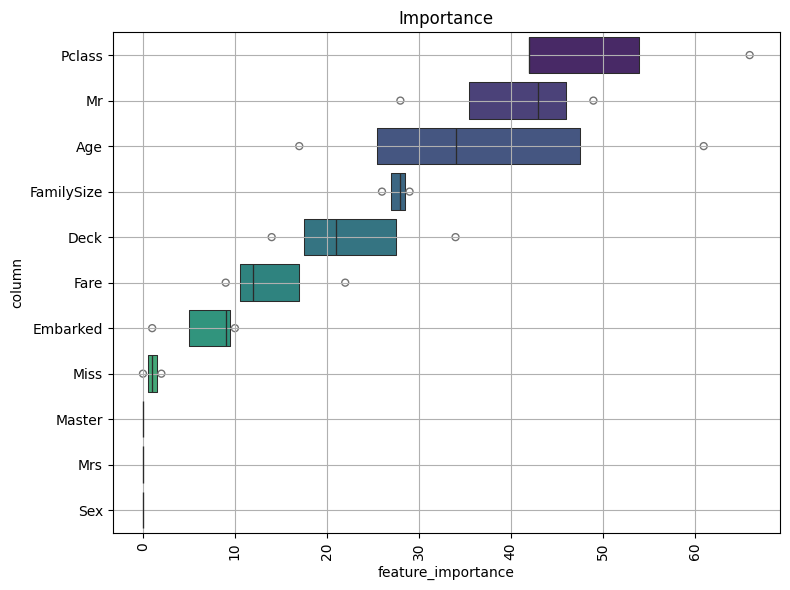

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = pd.Series(feat_train_df.columns)
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


models = []
for fold in range(CFG.N_SPLIT):
    model = pickle.load(
        open(
            CFG.MODEL_DATA_PATH
            / f"{CFG.AUTHOR}_lightgbm_{CFG.target_col}_fold{fold + 1}_seed{CFG.SEED}_ver{CFG.VER}.pkl",
            "rb",
        )
    )
    models.append(model)

fig, ax = visualize_importance(models, feat_train_df)

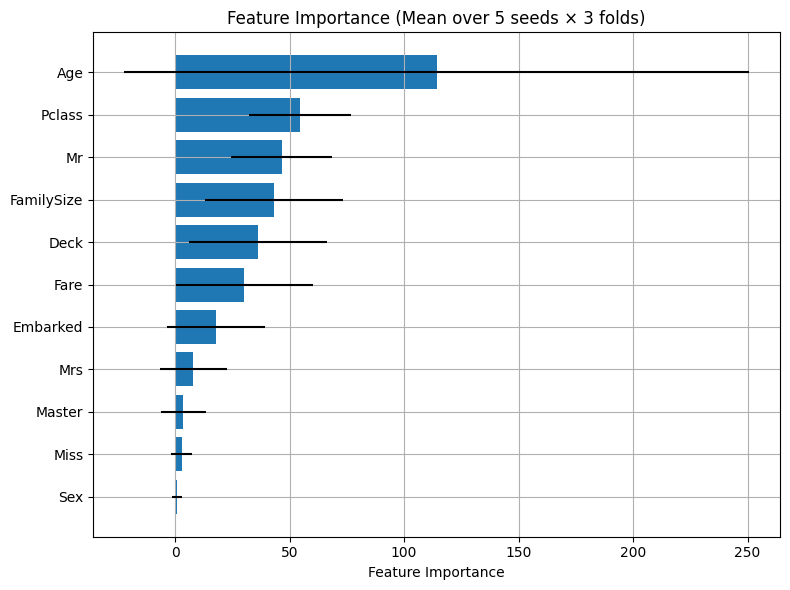

In [67]:
# 全シードの平均importanceを計算
all_importances = []
for seed_idx in range(CFG.N_SEEDS):
    seed = CFG.SEED + seed_idx
    for fold in range(CFG.N_SPLIT):
        model = pickle.load(
            open(
                CFG.MODEL_DATA_PATH
                / f"{CFG.AUTHOR}_lightgbm_{CFG.target_col}_fold{fold + 1}_seed{seed}_ver{CFG.VER}.pkl",
                "rb",
            )
        )
        all_importances.append(model.feature_importance())

# 平均importance
mean_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

importance_df = pd.DataFrame({
    'feature': feat_train_df.columns,
    'importance': mean_importance,
    'std': std_importance
}).sort_values('importance', ascending=False).head(50)

fig, ax = plt.subplots(figsize=(8, max(6, len(importance_df) * 0.25)))
ax.barh(importance_df['feature'], importance_df['importance'], xerr=importance_df['std'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title(f'Feature Importance (Mean over {CFG.N_SEEDS} seeds × {CFG.N_SPLIT} folds)')
ax.grid()
fig.tight_layout()
plt.show()

## Histrical plot of predictions

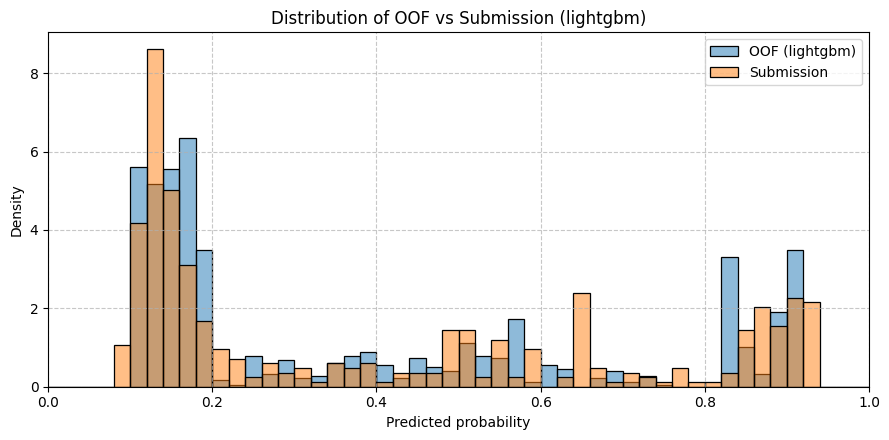

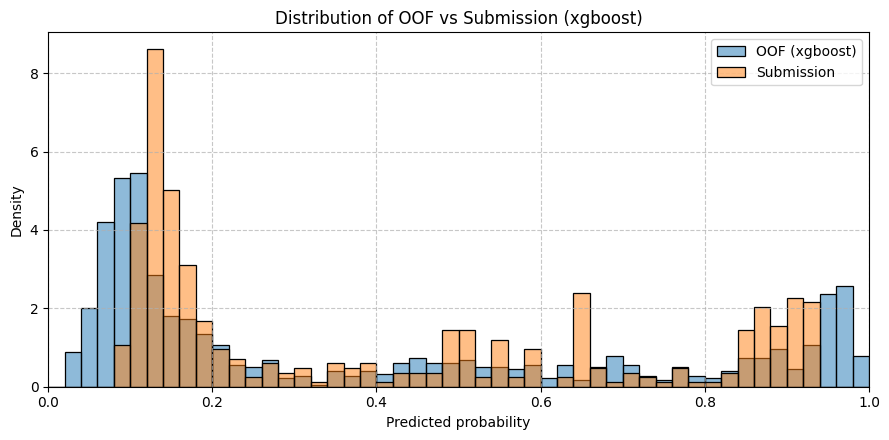

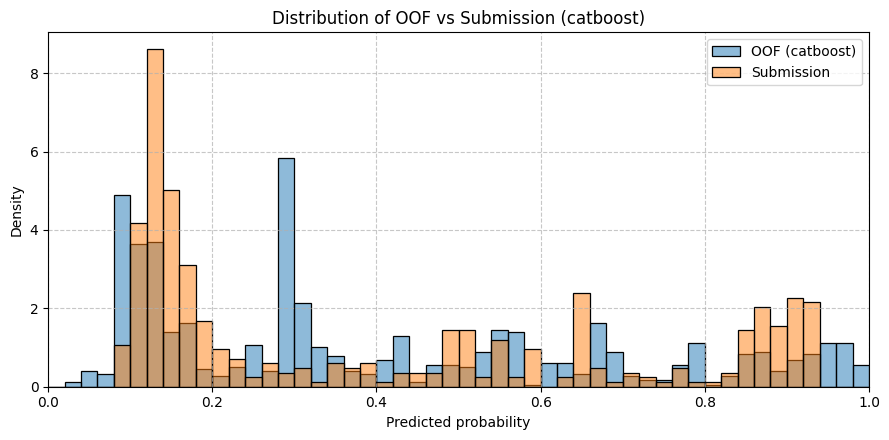

In [68]:
def plot_oof_vs_submission_hist(method_list, submission_df, bins=30):
    # 0～1の同一ビンを全モデルで共有
    bin_edges = np.linspace(0.0, 1.0, bins + 1)

    for m in method_list:
        oof_path = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{m}_seed{CFG.SEED}_ver{CFG.VER}.csv"
        oof_df = pd.read_csv(oof_path)

        # 可視化
        plt.figure(figsize=(9, 4.5))
        sns.histplot(
            oof_df[CFG.target_col].clip(0, 1),  # 念のため0-1にクリップ
            label=f"OOF ({m})",
            stat="density",
            bins=bin_edges,
            alpha=0.5,
        )
        sns.histplot(
            submission_df[CFG.target_col].clip(0, 1),
            label="Submission",
            stat="density",
            bins=bin_edges,
            alpha=0.5,
        )
        plt.xlim(0, 1)
        plt.xlabel("Predicted probability")
        plt.ylabel("Density")
        plt.title(f"Distribution of OOF vs Submission ({m})")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()


plot_oof_vs_submission_hist(CFG.METHOD_LIST, submission_df, bins=50)

## ROC AUC

In [69]:
import numpy as np


def check_y_and_pred(y_true, y_pred):
    """Ensure y_true/y_pred are 2D arrays aligned for PR/ROC plots."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if y_true.ndim == 1:
        unique_vals = np.unique(y_true)
        if set(unique_vals).issubset({0, 1}):
            y_true_proc = np.stack([1 - y_true, y_true], axis=1)
            classes = np.array([0, 1])
        else:
            classes = unique_vals
            y_true_proc = np.vstack([(y_true == c).astype(int) for c in classes]).T
    else:
        y_true_proc = y_true
        classes = np.arange(y_true.shape[1])

    if y_pred.ndim == 1:
        if y_true_proc.shape[1] == 2:
            y_pred_proc = np.stack([1 - y_pred, y_pred], axis=1)
        else:
            raise ValueError("Expected multi-class probabilities for y_pred")
    else:
        y_pred_proc = y_pred

    return y_true_proc, y_pred_proc, classes

In [70]:
def load_oof_preds(method: str, train_df: pd.DataFrame) -> np.ndarray:
    """OOFファイル群を読み込み、train_df.index に沿った平均予測を返す"""
    per_seed_preds = []
    for seed_idx in range(CFG.N_SEEDS):
        seed = CFG.SEED + seed_idx
        path = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{method}_seed{seed}_ver{CFG.VER}.csv"
        oof = pd.read_csv(path)
        if "row_id" not in oof.columns:
            raise ValueError(
                f"OOF file for {method} has no 'row_id'. 学習側で row_id を保存してください。"
            )
        ordered = oof.set_index("row_id").loc[train_df.index]
        per_seed_preds.append(ordered[CFG.target_col].astype(float).values)

    if not per_seed_preds:
        raise ValueError(f"No OOF files found for {method}")

    return np.mean(per_seed_preds, axis=0)

## Precision Recall Curve

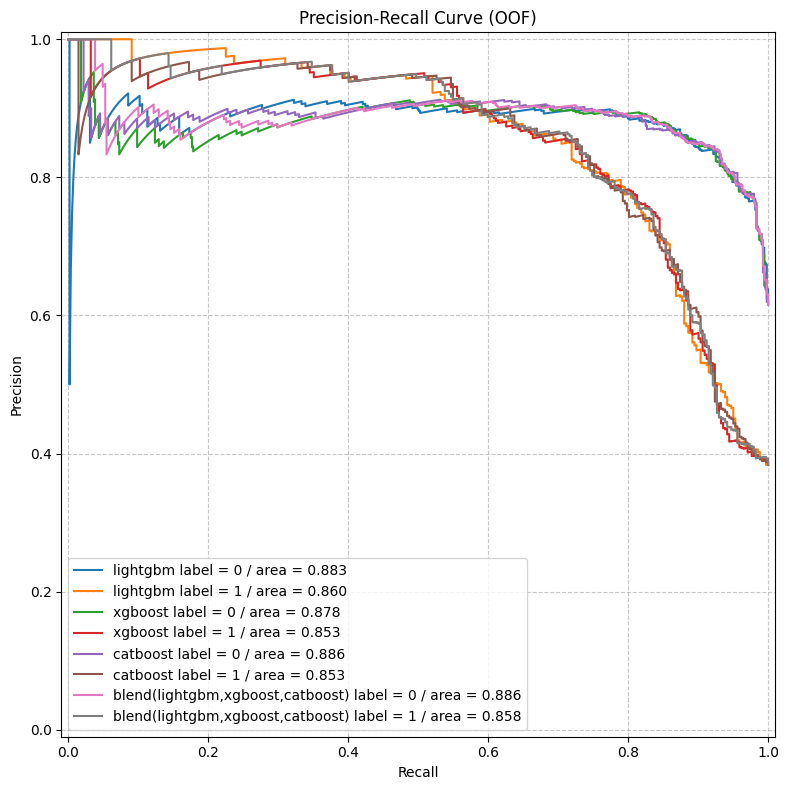

In [71]:
from sklearn.metrics import precision_recall_curve, average_precision_score


def visualize_pr_curve(
    y_true, y_pred, ax: Optional[plt.Axes] = None, label_prefix: Optional[str] = None
) -> [Optional[plt.Figure], plt.Axes]:
    precision = dict()
    recall = dict()
    pr_score = dict()
    y_true, y_pred, classes = check_y_and_pred(y_true, y_pred)
    n_classes = len(classes)

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        pr_score[i] = average_precision_score(y_true[:, i], y_pred[:, i])

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    else:
        fig, ax = None, ax

    for i in range(n_classes):
        label_i = f"label = {i} / area = {pr_score[i]:.3f}"
        if label_prefix is not None:
            label_i = f"{label_prefix} {label_i}"
        ax.plot(recall[i], precision[i], label=label_i)

    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ax.grid()
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision Recall Curve")
    ax.legend(loc="lower left")
    return fig, ax


def plot_oof_pr_curve(method_list: list, train_df: pd.DataFrame, add_blend: bool = True):
    """
    指定メソッドの OOF 予測で Precision-Recall カーブを重ね描き。
    add_blend=True のときは重み付きブレンドも併記。
    """
    y_true = train_df[CFG.target_col].values

    first = True
    fig, ax = None, None

    for m in method_list:
        y_pred = load_oof_preds(m, train_df)  # ← ROC用に作ったユーティリティをそのまま使える
        fig, ax = visualize_pr_curve(y_true=y_true, y_pred=y_pred, ax=ax, label_prefix=m)
        if first:
            first = False

    if add_blend:
        weights = np.array([CFG.METHOD_WEIGHT_DICT[m] for m in method_list], dtype=float)
        weights = weights / weights.sum()

        pred_mat = np.vstack([load_oof_preds(m, train_df) for m in method_list]).T
        blend_pred = (pred_mat * weights).sum(axis=1)

        _, ax = visualize_pr_curve(
            y_true=y_true, y_pred=blend_pred, ax=ax, label_prefix=f"blend({','.join(method_list)})"
        )

    ax.grid(True, linestyle="--", alpha=0.7)
    ax.set_title("Precision-Recall Curve (OOF)")
    plt.tight_layout()
    plt.show()


plot_oof_pr_curve(CFG.METHOD_LIST, train_full_df, add_blend=True)